In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [2]:
#load data
df1=pd.read_csv('datasets/Normal_data.csv')
df2=pd.read_csv('datasets/OVS.csv')

In [3]:
df = df1.merge(df2,how='outer')

In [4]:
#randomise the indexes but keep the original order of the rows
df = df.sample(frac=1, random_state = 42).reset_index(drop=True)
df

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,185.127.17.56-192.168.20.133-443-35934-6,185.127.17.56,443,192.168.20.133,35934,6,4/2/2020 18:27,4731,25,27,...,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,Normal
1,192.168.20.129-192.168.20.2-54941-53-17,192.168.20.2,53,192.168.20.129,54941,17,5/2/2020 11:59,623,1,1,...,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,Normal
2,192.168.20.134-200.175.2.130-10024-48537-6,200.175.2.130,48537,192.168.20.134,10024,6,26/12/2019 01:55:18 PM,1394,0,2,...,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,Probe
3,192.168.20.134-47.98.162.197-0-0-0,47.98.162.197,0,192.168.20.134,0,0,4/2/2020 15:20,2,0,2,...,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,DDoS
4,185.33.223.206-192.168.20.133-443-53174-6,192.168.20.133,53174,185.33.223.206,443,6,5/2/2020 14:28,19457923,17,17,...,0,602416.5,242378.5269,773804.0,431029.0,9126402.5,1233165.235,9998382.0,8254423.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207141,192.168.20.134-200.175.2.130-80-41620-6,200.175.2.130,41620,192.168.20.134,80,6,1/1/2020 23:19,24986,2,6,...,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,DoS
207142,192.168.20.134-43.125.117.168-0-0-0,43.125.117.168,0,192.168.20.134,0,0,4/2/2020 15:20,1,0,2,...,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,DDoS
207143,192.168.20.134-200.175.2.130-80-53420-6,200.175.2.130,53420,192.168.20.134,80,6,27/12/2019 05:04:32 PM,5734,2,1,...,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,DoS
207144,192.168.20.134-200.175.2.130-80-35814-6,200.175.2.130,35814,192.168.20.134,80,6,27/12/2019 05:05:23 PM,8989,2,6,...,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0,DoS


In [5]:
#putting underscored in place of spaces in the column names
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_'))
df.columns = cols
print(df.head())

                                      Flow_ID          Src_IP  Src_Port  \
0    185.127.17.56-192.168.20.133-443-35934-6   185.127.17.56       443   
1     192.168.20.129-192.168.20.2-54941-53-17    192.168.20.2        53   
2  192.168.20.134-200.175.2.130-10024-48537-6   200.175.2.130     48537   
3          192.168.20.134-47.98.162.197-0-0-0   47.98.162.197         0   
4   185.33.223.206-192.168.20.133-443-53174-6  192.168.20.133     53174   

           Dst_IP  Dst_Port  Protocol               Timestamp  Flow_Duration  \
0  192.168.20.133     35934         6          4/2/2020 18:27           4731   
1  192.168.20.129     54941        17          5/2/2020 11:59            623   
2  192.168.20.134     10024         6  26/12/2019 01:55:18 PM           1394   
3  192.168.20.134         0         0          4/2/2020 15:20              2   
4  185.33.223.206       443         6          5/2/2020 14:28       19457923   

   Tot_Fwd_Pkts  Tot_Bwd_Pkts  ...  Fwd_Seg_Size_Min  Active_Mean  \

In [8]:
print(df['Label'].value_counts())

Label
Normal    68424
DDoS      48413
Probe     36372
Name: count, dtype: int64


In [7]:
#dropping some label values
df = df.drop(df[df['Label'].isin(['DoS','BOTNET','Web-Attack','BFA'])].index)

In [9]:
df = df.drop(columns=['Timestamp','Src_IP', 'Dst_IP','Flow_ID'])

In [10]:
# changing attack labels into two categories 'normal' and 'abnormal'
df['Label'] = pd.DataFrame(df.Label.map(lambda x:'Normal' if x=='Normal' else 'Abnormal'))

In [11]:
print(df['Label'].value_counts())

Label
Abnormal    84785
Normal      68424
Name: count, dtype: int64


/home/iskadoodle/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


<Axes: xlabel='Label'>

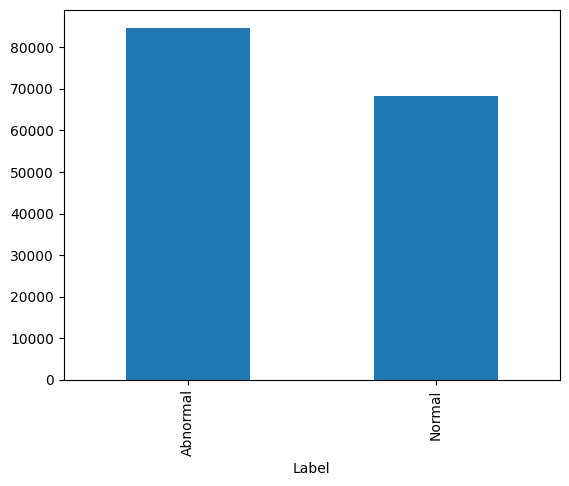

In [12]:
df['Label'].value_counts().plot(kind='bar')


In [13]:
# Prepare the dataset for feature selection
X = df.drop('Label', axis=1)
y = df['Label']

In [14]:
X

,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,...,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
0,443,35934,6,4731,25,27,59039.0,5200.0,5200,0,...,23,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0
1,53,54941,17,623,1,1,95.0,178.0,95,95,...,1,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0
2,48537,10024,6,1394,0,2,0.0,0.0,0,0,...,0,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0
3,0,0,0,2,0,2,0.0,0.0,0,0,...,0,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0
4,53174,443,6,19457923,17,17,6844.0,11782.0,1287,0,...,7,0,602416.5,242378.5269,773804.0,431029.0,9126402.5,1233165.235,9998382.0,8254423.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207135,0,0,0,1,0,2,0.0,0.0,0,0,...,0,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0
207136,0,0,0,1,0,2,0.0,0.0,0,0,...,0,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0
207139,52034,53,17,3990,1,3,34.0,690.0,34,34,...,1,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0
207140,0,0,0,2,0,2,0.0,0.0,0,0,...,0,0,0.0,0.0000,0.0,0.0,0.0,0.000,0.0,0.0


In [15]:
# Initialize the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Use RFE to select the top 10 features
from sklearn.feature_selection import RFE
rfe = RFE(clf, n_features_to_select=10)
rfe.fit(X, y)

# Get the names of the top 10 features
top_features = X.columns[rfe.support_].tolist()
print("Top 10 features:", top_features)

Top 10 features: ['Dst_Port', 'Tot_Fwd_Pkts', 'Flow_Byts/s', 'Fwd_Header_Len', 'Fwd_Pkts/s', 'Pkt_Len_Max', 'Pkt_Len_Mean', 'Pkt_Size_Avg', 'Subflow_Fwd_Pkts', 'Init_Bwd_Win_Byts']


In [16]:
print(rfe.support_)

[False  True False False  True False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
  True False  True False False  True  True False False False False False
 False False False False False False  True False False False False False
 False False False  True False False False False  True False False False
 False False False False False False False]


In [2]:
top_features = ['Dst_Port', 'Tot_Fwd_Pkts', 'Flow_Byts/s', 'Fwd_Header_Len', 'Fwd_Pkts/s', 'Pkt_Len_Max', 'Pkt_Len_Mean', 'Pkt_Size_Avg', 'Subflow_Fwd_Pkts', 'Init_Bwd_Win_Byts']

In [18]:
x=X[top_features]
x

,Dst_Port,Tot_Fwd_Pkts,Flow_Byts/s,Fwd_Header_Len,Fwd_Pkts/s,Pkt_Len_Max,Pkt_Len_Mean,Pkt_Size_Avg,Subflow_Fwd_Pkts,Init_Bwd_Win_Byts
0,35934,25,1.360000e+07,500,5284.295075,5200,1310.169811,1335.365385,25,0
1,54941,1,4.382022e+05,8,1605.136437,178,150.333333,225.500000,1,-1
2,10024,0,0.000000e+00,0,0.000000,0,0.000000,0.000000,0,0
3,0,0,0.000000e+00,0,0.000000,0,0.000000,0.000000,0,-1
4,443,17,9.572450e+02,340,0.873680,3900,532.171429,547.823529,17,64240
...,...,...,...,...,...,...,...,...,...,...
207135,0,0,0.000000e+00,0,0.000000,0,0.000000,0.000000,0,-1
207136,0,0,0.000000e+00,0,0.000000,0,0.000000,0.000000,0,-1
207139,53,1,1.814536e+05,8,250.626566,334,151.600000,189.500000,1,-1
207140,0,0,0.000000e+00,0,0.000000,0,0.000000,0.000000,0,-1


In [19]:
y

0           Normal
1           Normal
2         Abnormal
3         Abnormal
4           Normal
            ...   
207135    Abnormal
207136    Abnormal
207139      Normal
207140    Abnormal
207142    Abnormal
Name: Label, Length: 153209, dtype: object

In [20]:
x.to_csv('X_balanced_bin2.csv',index=False)
y.to_csv('Y_balanced_bin2.csv',index=False)

In [3]:
# Create a DataFrame
df_top_features = pd.DataFrame({'Top Features for Binary classification of Normal and Attack labels': top_features})

# Display the DataFrame
print(df_top_features)

  Top Features for Binary classification of Normal and Attack labels
0                                           Dst_Port                
1                                       Tot_Fwd_Pkts                
2                                        Flow_Byts/s                
3                                     Fwd_Header_Len                
4                                         Fwd_Pkts/s                
5                                        Pkt_Len_Max                
6                                       Pkt_Len_Mean                
7                                       Pkt_Size_Avg                
8                                   Subflow_Fwd_Pkts                
9                                  Init_Bwd_Win_Byts                
